## Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.stats import randint as sp_randint
from time import time
import nltk
nltk.download('wordnet')
import re
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\deepa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
mydf = pd.read_csv('C:\\Users\\deepa\\Desktop\\Womens_Clothing_E_Commerce_Reviews.csv')
mydf.drop(mydf.columns[0],inplace=True, axis=1)


### Droping Null Values and adding WordCount CharCount and Labeling the Rating 

In [3]:
# Delete missing observations for following variables
for x in ["Division Name","Department Name","Class Name","Review Text"]:
    mydf = mydf[mydf[x].notnull()]

# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in mydf.columns:
    unique_count.append([x,len(mydf[x].unique()),mydf[x].isnull().sum()])

# Missing Values
print("Missing Values: {}".format(mydf.isnull().sum().sum()))

# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*mydf.shape))

# Create New Variables: 
# Word Length
mydf["Word Count"] = mydf['Review Text'].str.split().apply(len)
# Character Length
mydf["Character Count"] = mydf['Review Text'].apply(len)

mydf["Label"] = 'Bad'
mydf.loc[mydf.Rating > 3,["Label"]] = 'Good'

Missing Values: 2966
Dataframe Dimension: 22628 Rows, 10 Columns


There are 2966 Null Values in the DataFrame in the the column Title 

In [4]:
print("Dataframe Dimension: {} Rows, {} Columns".format(*mydf.shape))
pd.DataFrame(unique_count, columns=["Column","Unique","Missing"]).set_index("Column").T


Dataframe Dimension: 22628 Rows, 13 Columns


Column,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
Unique,1172,77,13984,22621,5,2,82,3,6,20
Missing,0,0,2966,0,0,0,0,0,0,0


In [5]:
mydf.describe().T.drop(labels=["count"],axis=1)
#Desprictive statistics of the Dataset

,mean,std,min,25%,50%,75%,max
Clothing ID,919.695908,201.683804,1.0,861.0,936.0,1078.0,1205.0
Age,43.282880,12.328176,18.0,34.0,41.0,52.0,99.0
Rating,4.183092,1.115911,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.818764,0.385222,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.631784,5.787520,0.0,0.0,1.0,3.0,122.0
Word Count,60.211950,28.533053,2.0,36.0,59.0,88.0,115.0
Character Count,308.761534,143.934126,9.0,186.0,302.0,459.0,508.0


In the above code we are describing the DataFrame , displaying Datas Statistics

In [6]:
mydf[["Title","Division Name","Department Name","Class Name"]].describe(include=["O"]).T.drop(labels=["count"],axis=1)
#Count of each word occurence in the dataset

,unique,top,freq
Title,13983,Love it!,136
Division Name,3,General,13365
Department Name,6,Tops,10048
Class Name,20,Dresses,6145


### Analysis

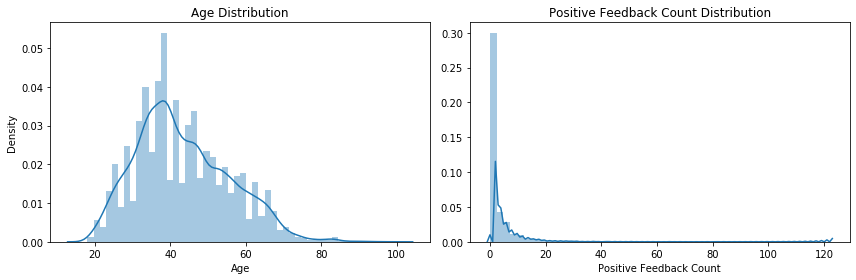

In [7]:
f, ax = plt.subplots(1,2,figsize=(12,4), sharey=False)
sns.distplot(mydf.Age, ax=ax[0])
ax[0].set_title("Age Distribution")
ax[0].set_ylabel("Density")
sns.distplot(mydf["Positive Feedback Count"], ax=ax[1])
ax[1].set_title("Positive Feedback Count Distribution")
plt.tight_layout()
plt.show()



Density of people from their respective age in the Data

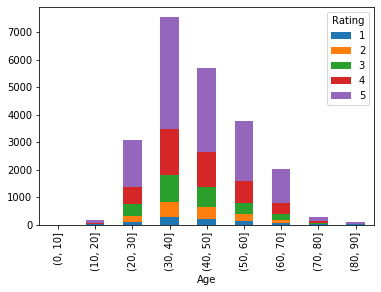

In [8]:
mydf.groupby(['Rating', pd.cut(mydf['Age'], np.arange(0,100,10))])\
       .size()\
       .unstack(0)\
       .plot.bar(stacked=True)

People with respective ages in the interval are ploted with respect to the rating given

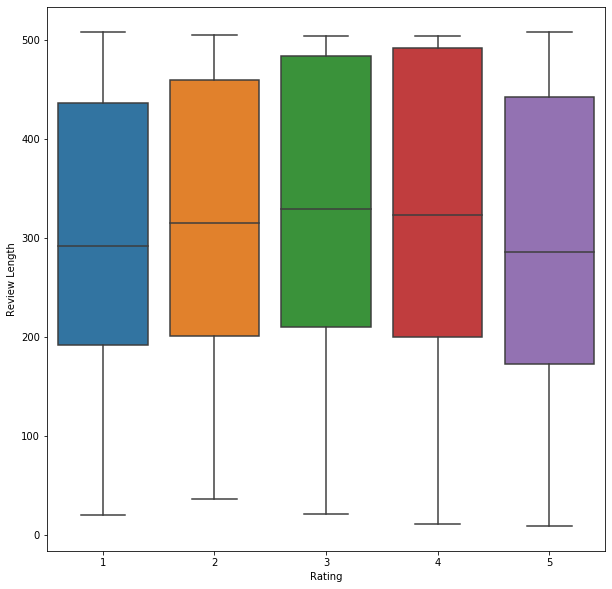

In [9]:
mydf['Review Text']=mydf['Review Text'].astype(str)
mydf['Review Length']=mydf['Review Text'].apply(len)
plt.figure(figsize=(10,10))
sns.boxplot(x='Rating', y='Review Length', data=mydf)

Converting the review to review length to check its effect on rating

Text(0.5, 1.0, 'Counts Vs Department Name')

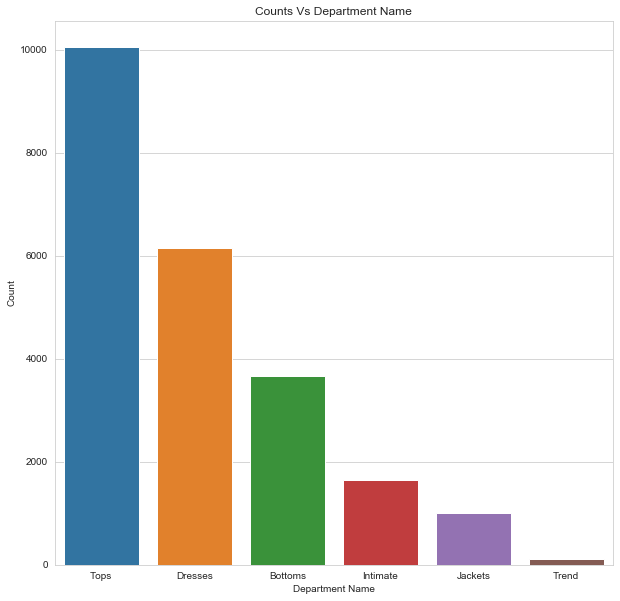

In [10]:
z=mydf.groupby(by=['Department Name'],as_index=False).count().sort_values(by='Class Name',ascending=False)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['Department Name'],y=z['Class Name'], data=z)
plt.xlabel("Department Name")
plt.ylabel("Count")
plt.title("Counts Vs Department Name")

Frequency of Different types of Dresses

# Text Processing

In [11]:
mydf['Review Text'].fillna('Empty', inplace=True)


Filling all the Empty values with 'Empty'

In [12]:
stop = text.ENGLISH_STOP_WORDS

# Basic text cleaning function
def remove_noise(text):
    
    # Make lowercase
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Remove whitespaces
    text = text.apply(lambda x: " ".join(x.strip() for x in x.split()))
    
    # Remove special characters
    text = text.apply(lambda x: "".join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))
    
    # Remove punctuation
    text = text.str.replace('[^\w\s]', '')
    
    # Remove numbers
    text = text.str.replace('\d+', '')
    
    # Remove Stopwords
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    # Convert to string
    text = text.astype(str)
        
    return text

Removing Different types of Noise from the Review Text

In [13]:
mydf['Filtered Text'] = remove_noise(mydf['Review Text'])#Function Call

In [14]:
mydf

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Character Count,Label,Review Length,Filtered Text
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,8,53,Good,53,absolutely wonderful silky sexy comfortable
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,62,303,Good,303,love dress sooo pretty happened store im glad ...
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,98,500,Bad,500,high hopes dress really wanted work initially ...
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,22,124,Good,124,love love love jumpsuit fun flirty fabulous ti...
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,36,192,Good,192,shirt flattering adjustable tie perfect length...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses,28,131,Good,131,happy snag dress great price easy slip flatter...
23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits,38,223,Bad,223,reminds maternity clothes soft stretchy shiny ...
23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses,42,208,Bad,208,fit worked im glad able try store didnt order ...
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses,86,427,Bad,427,bought dress wedding summer cute unfortunately...


bloblist_desc = list()

df_review_str=mydf['Review Text'].astype(str)
for row in df_review_str:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['Review','sentiment','polarity'])

def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] > 0:
        val = "Positive Review"
    elif df_polarity_desc['sentiment'] == 0:
        val = "Neutral Review"
    else:
        val = "Negative Review"
    return val

df_polarity_desc['Sentiment_Type'] = df_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_polarity_desc)

In [15]:
def SentimentAnalyse(text):
    return text.apply(lambda Text: pd.Series(TextBlob(Text).sentiment.polarity))

# Applying function to reviews
mydf['Polarity'] = SentimentAnalyse(mydf['Filtered Text'])
mydf.head(10)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Character Count,Label,Review Length,Filtered Text,Polarity
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,8,53,Good,53,absolutely wonderful silky sexy comfortable,0.633333
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,62,303,Good,303,love dress sooo pretty happened store im glad ...,0.318750
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,98,500,Bad,500,high hopes dress really wanted work initially ...,0.037400
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,22,124,Good,124,love love love jumpsuit fun flirty fabulous ti...,0.500000
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,36,192,Good,192,shirt flattering adjustable tie perfect length...,0.750000
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,98,488,Bad,488,love tracy reese dresses petite just feet tall...,0.116667
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,101,496,Good,496,aded basket hte mintue look like person store ...,0.100833
7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits,97,482,Good,482,ordered carbon store pick ton stuff try used p...,0.145513
8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses,34,166,Good,166,love dress usually xs runs little snug bust or...,-0.046875
9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses,72,360,Good,360,im lbs ordered s petite make sure length wasnt...,0.250476


Performing Sentiment Analysis on the Filterd Text to Find the Polarity

In [16]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Define a word lemmatizer function
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

# Apply the word lemmatizer function to data
mydf['Filtered Text'] = mydf['Filtered Text'].apply(lemmatize_text)

In [17]:
mydf

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Character Count,Label,Review Length,Filtered Text,Polarity
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,8,53,Good,53,"[absolutely, wonderful, silky, sexy, comfortable]",0.633333
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,62,303,Good,303,"[love, dress, sooo, pretty, happened, store, i...",0.318750
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,98,500,Bad,500,"[high, hope, dress, really, wanted, work, init...",0.037400
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,22,124,Good,124,"[love, love, love, jumpsuit, fun, flirty, fabu...",0.500000
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,36,192,Good,192,"[shirt, flattering, adjustable, tie, perfect, ...",0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses,28,131,Good,131,"[happy, snag, dress, great, price, easy, slip,...",0.677778
23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits,38,223,Bad,223,"[reminds, maternity, clothes, soft, stretchy, ...",0.191667
23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses,42,208,Bad,208,"[fit, worked, im, glad, able, try, store, didn...",0.440000
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses,86,427,Bad,427,"[bought, dress, wedding, summer, cute, unfortu...",0.450000


In [18]:
cvec = CountVectorizer(min_df=.005, max_df=.9, ngram_range=(1,2), tokenizer=lambda doc: doc, lowercase=False)
cvec.fit(mydf['Filtered Text'])

C:\Users\deepa\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=0.9, max_features=None, min_df=0.005,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function <lambda> at 0x000001965D21E828>,
                vocabulary=None)

Using TF-IDF to get the text into MatrixFormat

In [19]:
cvec_counts = cvec.transform(mydf['Filtered Text'])
transformer = TfidfTransformer()

# Fitting and transforming n-grams
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

<22628x908 sparse matrix of type '<class 'numpy.float64'>'
	with 474877 stored elements in Compressed Sparse Row format>

In [20]:
transformed_weights = transformed_weights.toarray()
vocab = cvec.get_feature_names()

# Putting weighted n-grams into a DataFrame and computing some summary statistics
model = pd.DataFrame(transformed_weights, columns=vocab)
model['Keyword'] = model.idxmax(axis=1)
model['Max'] = model.max(axis=1)
model['Sum'] = model.drop('Max', axis=1).sum(axis=1)
model.head(10)

,able,absolutely,absolutely love,actually,add,added,addition,adorable,adore,afraid,...,year,yellow,yes,yesterday,youre,zip,zipper,Keyword,Max,Sum
0,0.0,0.384328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,silky,0.548700,2.180334
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,bc,0.462192,4.592337
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.178653,0.156816,layer,0.450171,5.222070
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,love love,0.648354,2.698862
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,shirt,0.442404,3.275608
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,dress,0.383198,4.747349
6,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,trying,0.515442,4.143620
7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,went,0.334111,4.851432
8,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,run little,0.334538,4.096254
9,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.179038,0.000000,0.000000,s,0.295521,5.904906


Weights of Each Word Used in the Review Text

In [21]:
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'Term': cvec.get_feature_names(), 'Occurrences': occ})
counts_df.sort_values(by='Occurrences', ascending=False).head(25)

,Term,Occurrences
179,dress,11320
241,fit,10093
682,size,9353
450,love,8962
412,like,7017
112,color,6902
436,look,6872
857,wear,6507
295,great,6073
347,im,5987


Occurences of word in Review Text

Good    17435
Bad      5193
Name: Label, dtype: int64


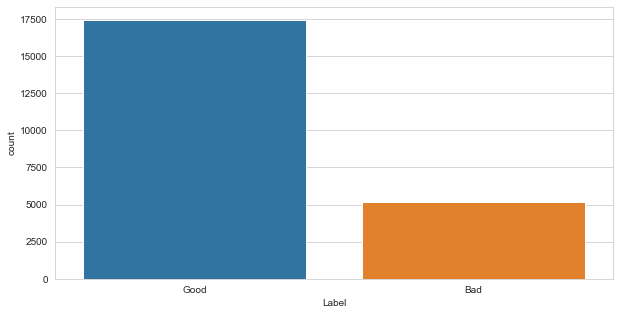

In [22]:
fig = plt.figure(figsize = (10,5))
sns.countplot(x='Label', data = mydf)

print(mydf['Label'].value_counts())

Target Variable Analysis

In [23]:
import string
def text_process(review):
    nopunc=[word for word in review if word not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Preprocessing the Text before Vectorizing it

In [24]:
mydf=mydf.dropna(axis=0,how='any')
X_review=mydf['Review Text']
y=mydf['Label']

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer=CountVectorizer(analyzer=text_process).fit(X_review)

Tf-Idf Vectotizer

In [26]:
X_review = bow_transformer.transform(X_review)

#### Using Naive Bayes Classifer

In [1]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_review, y, test_size=0.3, random_state=101)

NameError: name 'X_review' is not defined

In [28]:
from sklearn.naive_bayes import MultinomialNB#Using Naive Bayes Model
nb = MultinomialNB()
nb.fit(X_train, y_train)

TypeError: __init__() got an unexpected keyword argument 'cv'

In [ ]:
predict=nb.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, predict))#Plotting The confusion Matrix and the report of Classification
print('\n')
print(classification_report(y_test, predict))

#### Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_review, y, test_size=0.3, random_state=101)

log = LogisticRegression()
log.fit(X_train, y_train)
predict=log.predict(X_test)
print(confusion_matrix(y_test, predict))#Plotting The confusion Matrix and the report of Classification
print('\n')
print(classification_report(y_test, predict))

##### Random Forest Classifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_review, y, test_size=0.3, random_state=101)
ran = RandomForestClassifier(n_estimators=50)
ran.fit(X_train, y_train)
predict=ran.predict(X_test)
print(confusion_matrix(y_test, predict))#Plotting The confusion Matrix and the report of Classification
print('\n')
print(classification_report(y_test, predict))

##### KNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_review, y, test_size=0.3, random_state=101)
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(X_train, y_train)
predict = classifier.predict(X_test)


In [ ]:
print(confusion_matrix(y_test, predict))#Plotting The confusion Matrix and the report of Classification
print('\n')
print(classification_report(y_test, predict))